In [1]:
#Import library
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker


In [8]:
def read_paf(file, max_divergence, min_LEN):
    paf = pd.read_csv(file, sep='\t', header=None)
    paf.columns=["QUERY", "LEN2", "S2", "E2", "strand", "REF", "LEN1", "S1", "E1", "Match", "Block", "MapQ", "Type of aln", "Chaining score", "Chaining score of the best secondary chain", 'per-base-divergence', 'Length of repetitive sequence', 'per-base-divergence of repetitive seeds']
    paf = paf[paf['Block'] >= min_LEN]
    #For column after 11, split by ':' 
    for i in range(12, len(paf.columns)):
        paf[paf.columns[i]] = paf[paf.columns[i]].apply(lambda x: x.split(':')[2] if isinstance(x, str) and len(x.split(':')) > 2 else x)
    paf['per-base-divergence'] = paf['per-base-divergence'].apply(lambda x: float(x) if x is not None else None)
    paf = paf[paf['per-base-divergence'] <= max_divergence]
    return paf


In [9]:
Au3_paf = read_paf('../../data/Au3_hapB_AU3.paf', 0.2, 1000)

In [16]:
Au3_paf = pd.read_csv('../../data/Au3_hapB_AU3.paf', sep='\t', header=None)
Au3_paf.columns=["QUERY", "LEN2", "S2", "E2", "strand", "REF", "LEN1", "S1", "E1", "Match", "Block", "MapQ", "Type of aln", "Number of minimizers on the chain", "Chaining score", "Chaining score of the best secondary chain", 'per-base-divergence', 'Length of repetitive sequence']

In [17]:
Au3_paf['QUERY'] = Au3_paf['QUERY'].apply(lambda x: x.split('_')[3] + "B")
Au3_paf['REF'] = Au3_paf['REF'].apply(lambda x: x.split('_')[2] + "A")
#Au3_paf['per-base-divergence'] = Au3_paf['per-base-divergence'].str.split(':').str[2].astype(float)
Au3_paf['per-base-divergence'] = Au3_paf['per-base-divergence'].str.split(':').str[2].astype(float)
Au3_paf = Au3_paf[Au3_paf['per-base-divergence'] <= 0.2]
Au3_paf['IDY'] = (1 - Au3_paf['per-base-divergence'])
Au3_paf['IDY'] = Au3_paf['IDY']*100
Au3_paf = Au3_paf[Au3_paf['Block'] >= 1000]

In [18]:
Au3_paf = Au3_paf[Au3_paf['Block'] >= 1000]
Au3_paf = Au3_paf[Au3_paf['per-base-divergence'] <= 0.2]

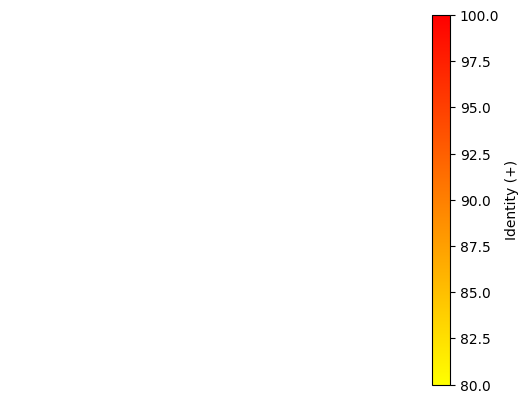

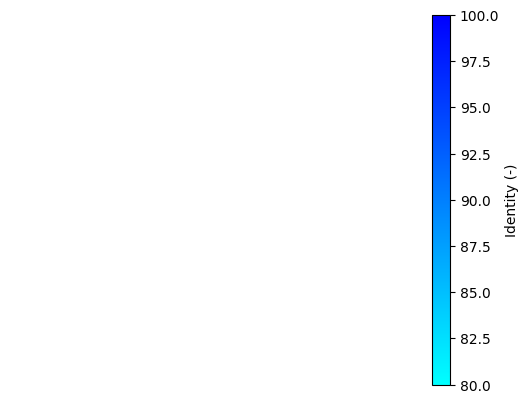

In [2]:
#Make a colour palette
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', ['yellow', 'red'])
cmap2 = mcolors.LinearSegmentedColormap.from_list('my_cmap', ['cyan', 'blue'])
norm = plt.Normalize(80, 100)
#Forward Strand
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'
fig, ax = plt.subplots()
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Identity (+)')
ax.axis('off')
plt.savefig('color_scale1.svg', dpi=300, format='svg', transparent=True, bbox_inches='tight')
plt.show()
#Reverse Strand
fig, ax = plt.subplots()
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap2)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Identity (-)')
ax.axis('off')
    
#plt.savefig('color_scale2.svg', dpi=300, format='svg', transparent=True, bbox_inches='tight')
plt.show()

In [8]:
def makeplot(paf, fsize, file_name):
    rows=len(paf["QUERY"].unique())
    cols=len(paf["REF"].unique())
    scale = 1000000
    fig, ax = plt.subplots(rows, cols,
                       sharex='col', 
                       sharey='row', figsize=(fsize*cols,fsize*rows))
    x_chromosome = paf["QUERY"].unique()
    #Sort by value
    x_chromosome = x_chromosome[np.argsort(x_chromosome)]
    y_chromosome = paf["REF"].unique()
    y_chromosome = y_chromosome[np.argsort(y_chromosome)]
    #Reverse y_chromosome order
    y_chromosome = y_chromosome[::-1]
    for row in range(rows):
        for col in range(cols):
            filter_paf = paf[(paf.QUERY.isin([x_chromosome[row]])) & (paf.REF.isin([y_chromosome[col]]))]
            if len(filter_paf) > 0 :
                for index, line in filter_paf.iterrows():        
                    if line['strand'] == '+':
                   #     ax[col,row].set(xlabel=filter_paf["QUERY"].unique())
                        point1 = [line['S1']/scale, line['S2']/scale]
                        point2 = [line['E1']/scale, line['E2']/scale]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['IDY']]
                        ax[col,row].plot(x_tmp, y_tmp, linewidth=1.5, color=cmap(norm(identity)))                      
                    if line['strand'] == '-':
                  #      ax[col,row].set(xlabel=filter_paf["QUERY"].unique())
                        point1 = [line['S1']/scale, line['S2']/scale]
                        point2 = [line['E1']/scale, line['E2']/scale]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['IDY']]
                        ax[col,row].plot(x_tmp, y_tmp, linewidth=1.5, color=cmap2(norm(identity)))
                if row == 0:
                    ax[col,row].set(ylabel=filter_paf["REF"].unique())
                if col == max(range(cols)):
                    ax[col,row].set(xlabel=filter_paf["QUERY"].unique())
                # Replace '0' with an empty string
                ax[col,row].set_xticks(np.arange(0, 100000000/scale, 10000000/scale))
                ax[col,row].set_yticks(np.arange(0, 100000000/scale, 10000000/scale))
                xticks_labels = np.arange(0, 100000000/scale, 10000000/scale).tolist()
                yticks_labels = np.arange(0, 100000000/scale, 10000000/scale).tolist()
                xticks_labels = [int(x) for x in xticks_labels]
                yticks_labels = [int(y) for y in yticks_labels]
                if row != 0:
                    xticks_labels = ['' if x == 0 else x for x in xticks_labels]
                if col != max(range(cols)):
                    yticks_labels = ['' if y == 0 else y for y in yticks_labels]
                # Set the new tick labels
                ax[col, row].set_xticklabels(xticks_labels)
                ax[col, row].set_yticklabels(yticks_labels)
                #Set maximum axis limit based on chromosome LEN1 and LEN2
                ax[col,row].set_xlim(0, (filter_paf["LEN2"]/scale).unique())
                ax[col,row].set_ylim(0, (filter_paf["LEN1"]/scale).unique())
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(file_name, dpi=300)
    plt.show()

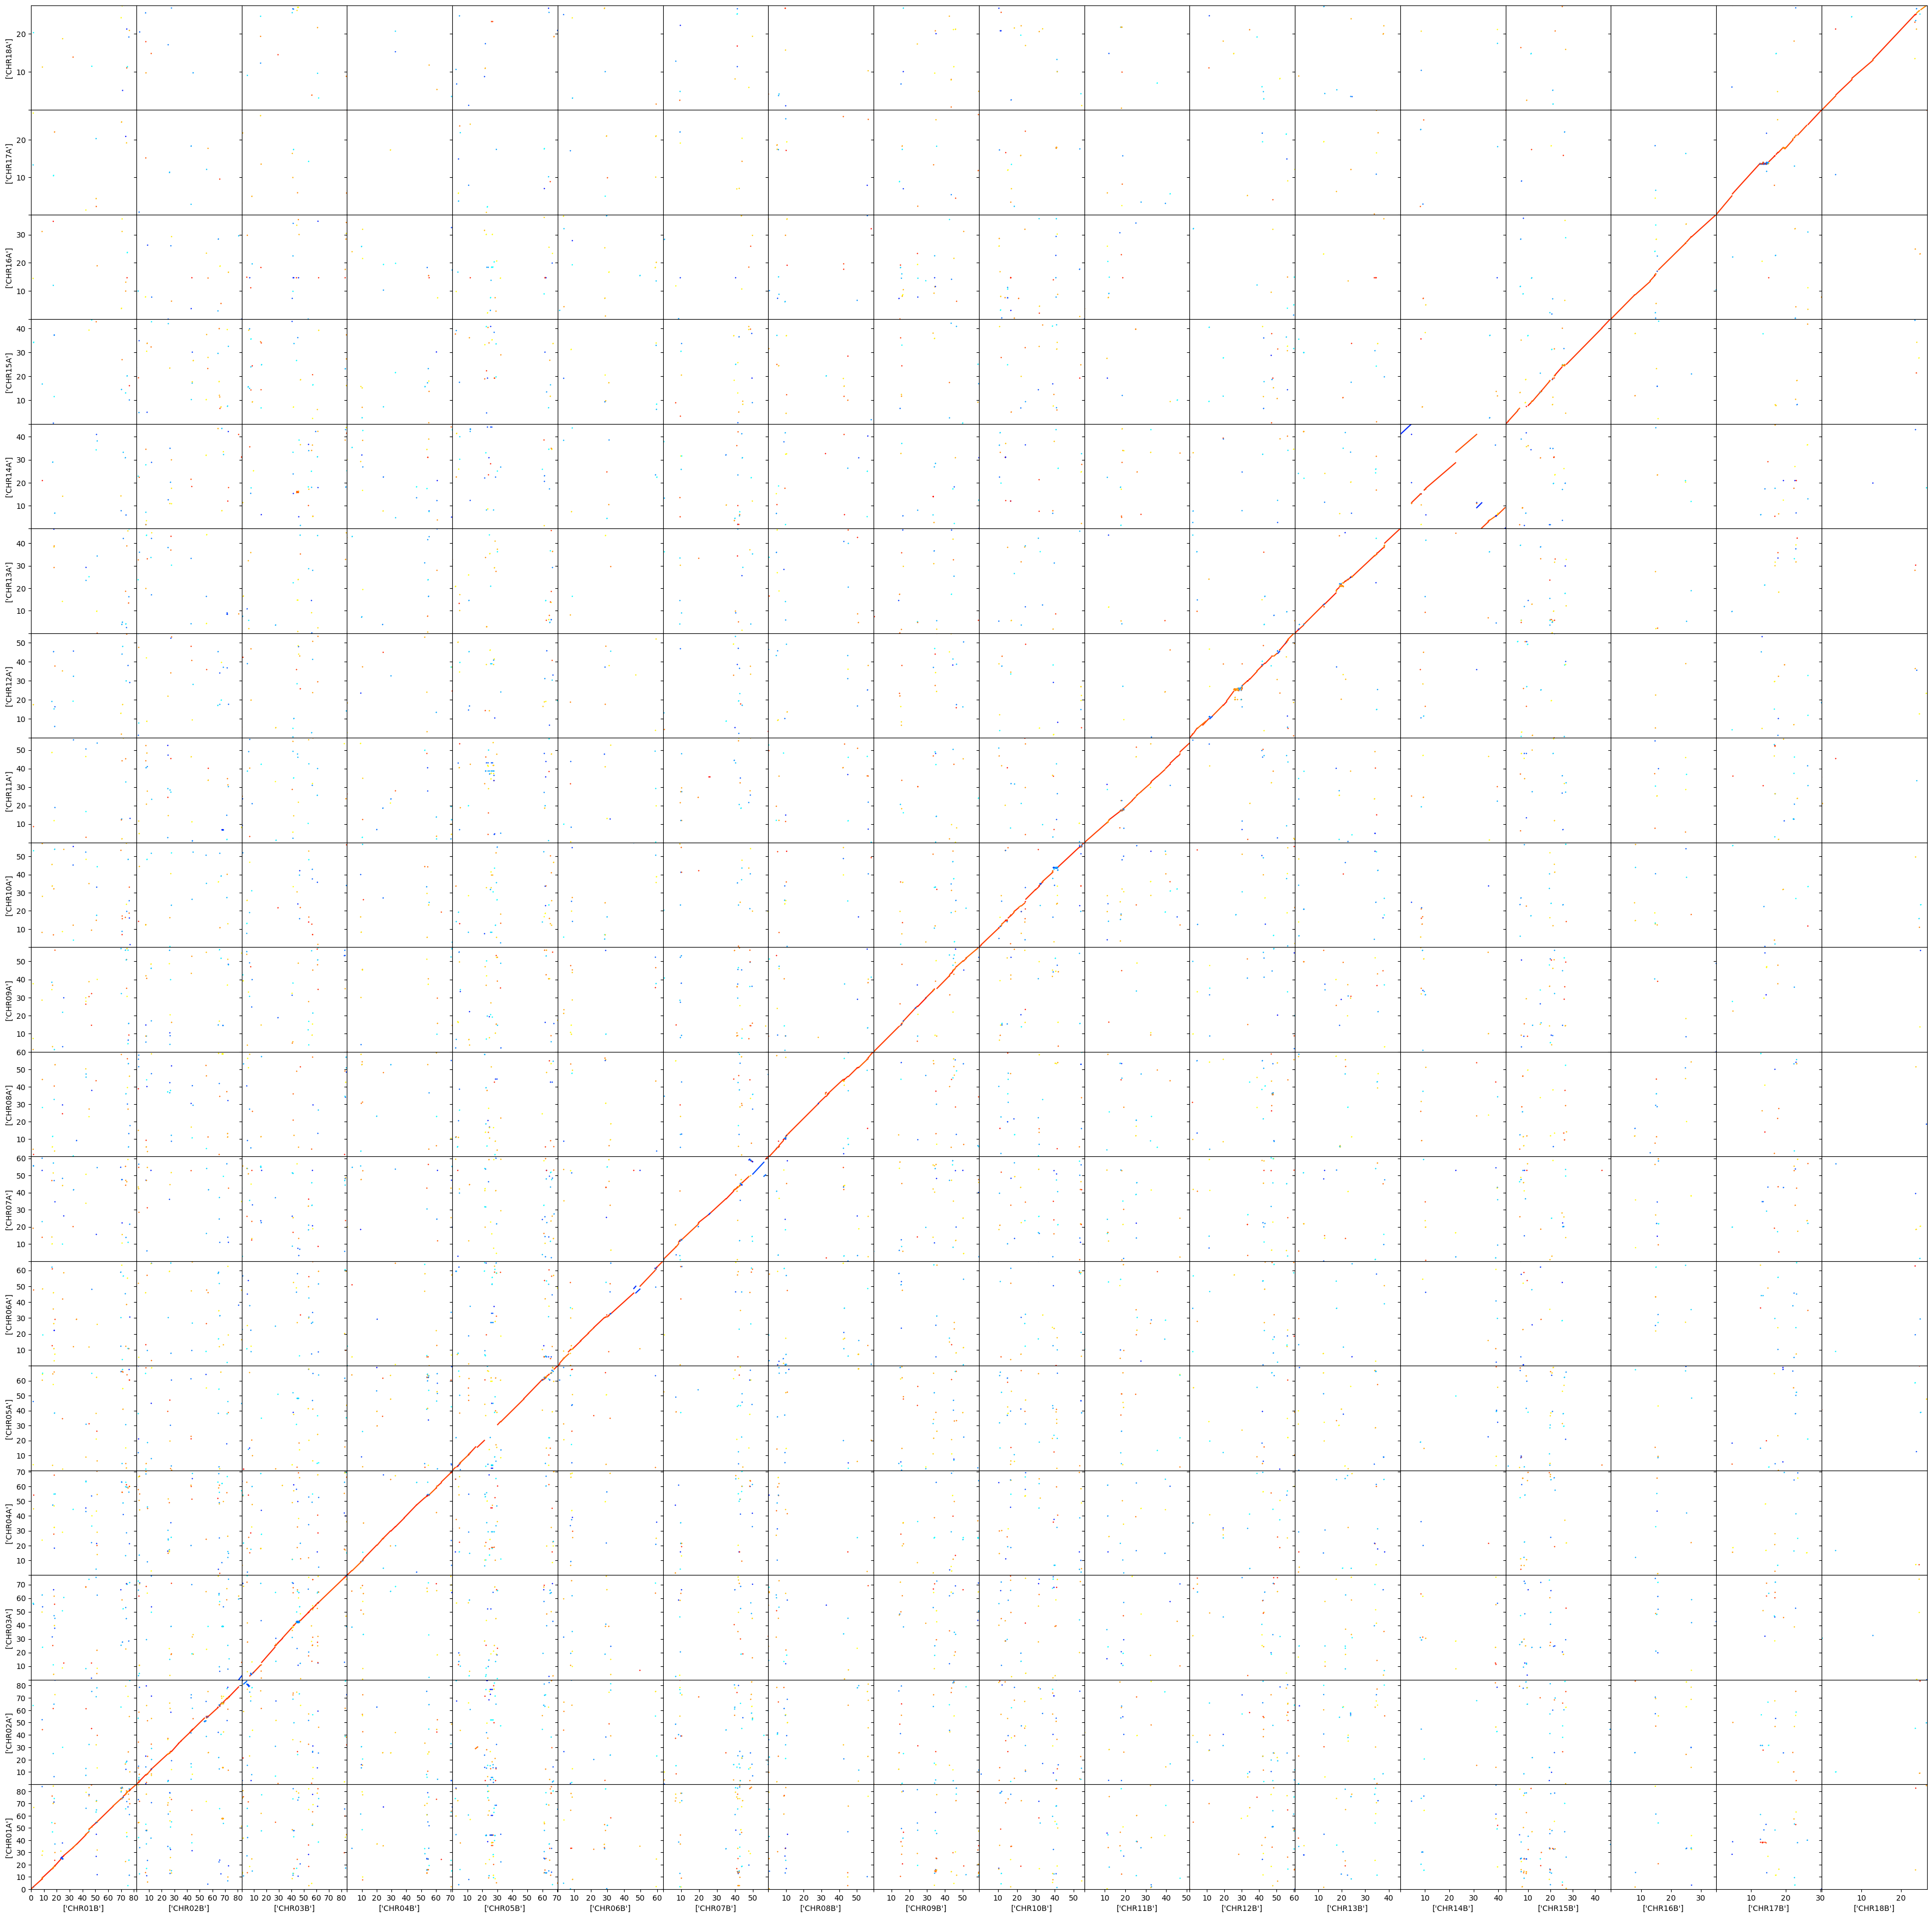

In [62]:
makeplot(Au3_paf, 2.5, 'Au3_dotplot.png')

In [9]:
def makeplot(paf, fsize, file_name):
    x_chromosome = paf["QUERY"].unique()
    y_chromosome = paf["REF"].unique()
    
    # Sort chromosomes by value
    x_chromosome = x_chromosome[np.argsort(x_chromosome)]
    y_chromosome = y_chromosome[np.argsort(y_chromosome)][::-1]  # Reverse y_chromosome order
    
    rows = len(y_chromosome)
    cols = len(x_chromosome)
    
    # Calculate the maximum lengths for each chromosome
    max_len2 = paf.groupby('QUERY')['LEN2'].max().reindex(x_chromosome).values
    max_len1 = paf.groupby('REF')['LEN1'].max().reindex(y_chromosome).values
    
    # Normalize lengths to get relative sizes
    max_len2_normalized = max_len2 / max_len2.max()
    max_len1_normalized = max_len1 / max_len1.max()
    
    # Calculate the figure size based on the normalized lengths
    fig_width = fsize * cols * max_len2_normalized.sum()
    fig_height = fsize * rows * max_len1_normalized.sum()
    
    fig, ax = plt.subplots(rows, cols, figsize=(fig_width, fig_height),
                           gridspec_kw={'width_ratios': max_len2_normalized, 'height_ratios': max_len1_normalized},
                           sharex='col', sharey='row')
    
    scale = 1000000
    
    for row in range(rows):
        for col in range(cols):
            filter_paf = paf[(paf.QUERY == x_chromosome[col]) & (paf.REF == y_chromosome[row])]
            if len(filter_paf) > 0:
                for index, line in filter_paf.iterrows():
                    if line['strand'] == '+':
                        point1 = [line['S1']/scale, line['S2']/scale]
                        point2 = [line['E1']/scale, line['E2']/scale]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['IDY']]
                        ax[row, col].plot(x_tmp, y_tmp, linewidth=1.5, color=cmap(norm(identity)))
                    if line['strand'] == '-':
                        point1 = [line['S1']/scale, line['S2']/scale]
                        point2 = [line['E1']/scale, line['E2']/scale]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['IDY']]
                        ax[row, col].plot(x_tmp, y_tmp, linewidth=1.5, color=cmap2(norm(identity)))
                if row == max(range(rows)):
                    ax[row, col].set_xlabel(filter_paf["QUERY"].unique()[0], fontsize=6)
                if col == 0:
                    ax[row, col].set_ylabel(filter_paf["REF"].unique()[0], fontsize=6)
                # Replace '0' with an empty string
                ax[row, col].xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 100000000/scale, 10000000/scale)))
                ax[row, col].yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 100000000/scale, 10000000/scale)))
                xticks_labels = np.arange(0, 100000000/scale, 10000000/scale).tolist()
                yticks_labels = np.arange(0, 100000000/scale, 10000000/scale).tolist()
                xticks_labels = [int(x) for x in xticks_labels]
                yticks_labels = [int(y) for y in yticks_labels]
                if row != 0:
                    #Remove digits from the labels
                    xticks_labels = ['' if x == 0 else x for x in xticks_labels]
                    xticks_labels = ['' if x == 0 else x for x in xticks_labels]
                if col != max(range(cols)):
                    yticks_labels = ['' if y == 0 else y for y in yticks_labels]
                # Set the new tick labels
                ax[row, col].xaxis.set_major_formatter(ticker.FixedFormatter(xticks_labels))
                ax[row, col].yaxis.set_major_formatter(ticker.FixedFormatter(yticks_labels))
                ax[row, col].tick_params(axis='both', which='major', labelsize=4)
                #If col==0, not show yticks
                
                

                # Set maximum axis limit based on chromosome LEN1 and LEN2
                max_len1 = filter_paf["LEN1"].max() / scale
                max_len2 = filter_paf["LEN2"].max() / scale
                ax[row, col].set_xlim(0, max_len2)
                ax[row, col].set_ylim(0, max_len1)
                if col != 0:
                    ax[row, col].tick_params(left=False)
    
    plt.subplots_adjust(wspace=0, hspace=0)
  #  plt.savefig(file_name, dpi=300)
    plt.show()


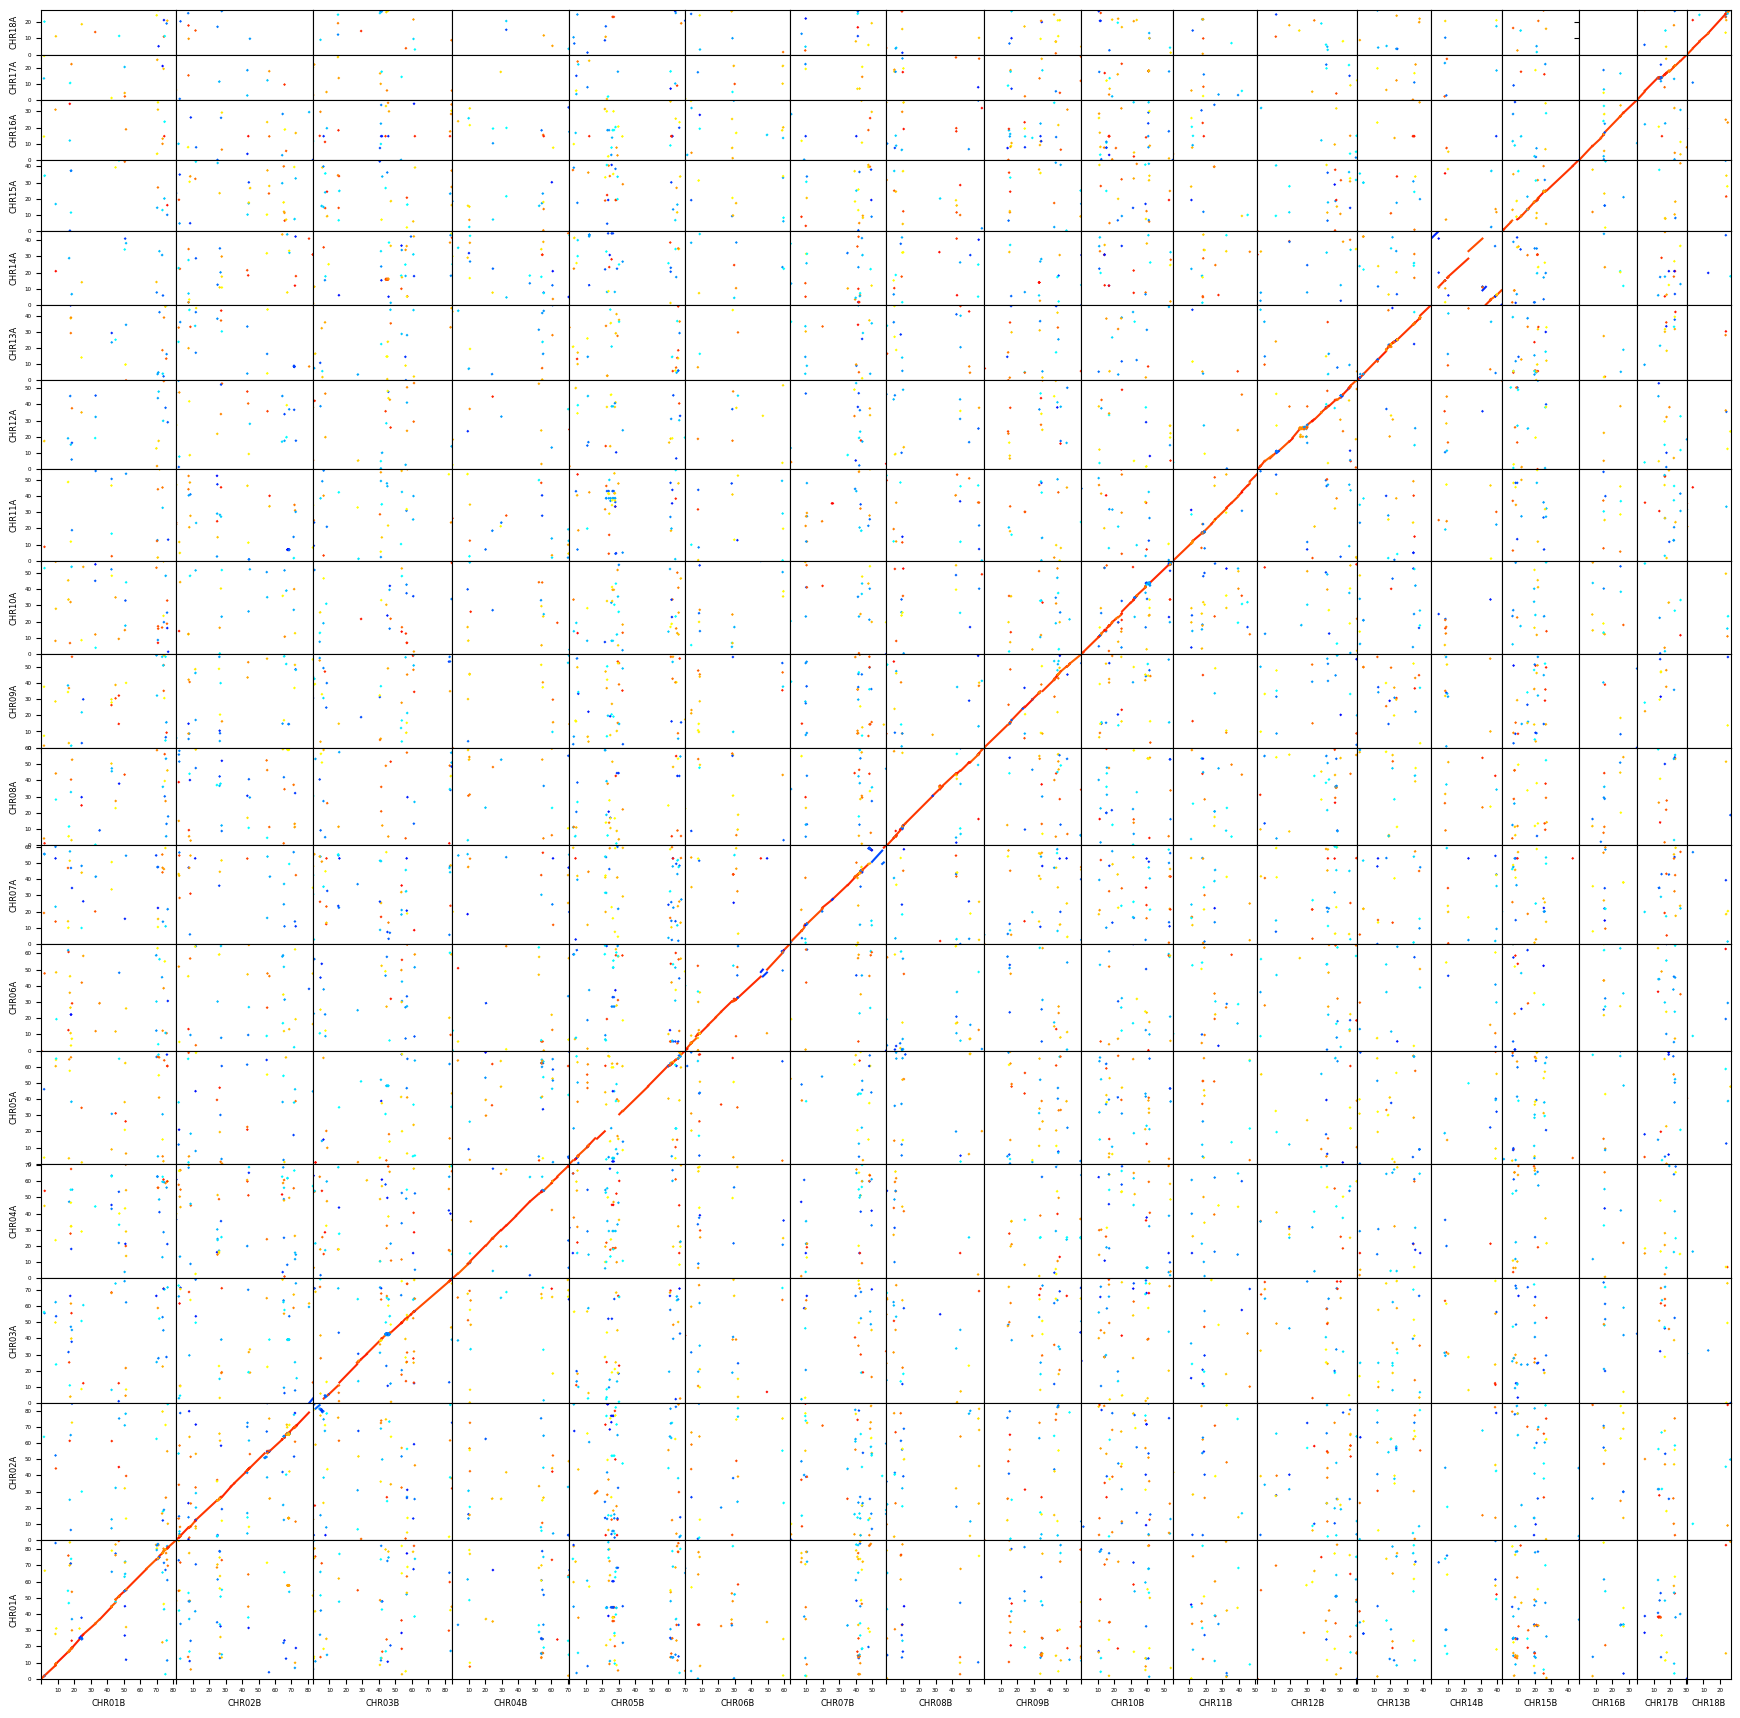

In [64]:
makeplot(Au3_paf, 0.1, 'Au3_dotplot.png')

In [56]:
centromere = pd.read_table('../../data/20250220_cen.table', header=None)
centromere.columns = ['Chr', 'Start', 'End']
centromere['Chr'] = centromere['Chr'].astype(str)
centromere['Start'] = centromere['Start'].astype(int)
centromere['End'] = centromere['End'].astype(int)
#Sort by chromosome and start position
centromere = centromere.sort_values(['Chr', 'Start'])
centromere['Chr']= centromere['Chr'].replace('Chr', 'CHR', regex=True)

In [58]:
centromere['start-2Mb'] = centromere['Start'] - 2000000
#If start-2Mb < 0, set to 0
centromere['start-2Mb'] = centromere['start-2Mb'].apply(lambda x: 0 if x < 0 else x)
centromere['end+2Mb'] = centromere['End'] + 2000000

In [59]:
centromere['Start|Mb'] = centromere['Start']/1000000
centromere['End|Mb'] = centromere['End']/1000000

In [73]:
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib as mpl
def zoomplot(paf, fsize, cen_df, file_name):
    mpl.rcParams['svg.fonttype'] = 'none'
    #get number from 01 to 18
    label = [str(i).zfill(2) for i in range(1, 19)]
    

    
    # Calculate the maximum lengths for each chromosome
#    max_len2 = paf.groupby('QUERY')['LEN2'].max().reindex(x_chromosome).values
#    max_len1 = paf.groupby('REF')['LEN1'].max().reindex(y_chromosome).values
    
    # Normalize lengths to get relative sizes
#    max_len2_normalized = max_len2 / max_len2.max()
#    max_len1_normalized = max_len1 / max_len1.max()
    
    # Calculate the figure size based on the normalized lengths
    fig_width = fsize * 5
    fig_height = fsize * 4
    
    fig, ax = plt.subplots(4, 5, figsize=(fig_width, fig_height))
    scale = 1000000
    
    for number in label:
            x_chr = 'CHR' + number + 'B'
            y_chr = 'CHR' + number + 'A'
            filter_paf = paf[(paf.QUERY == x_chr) & (paf.REF == y_chr)]
    #Divide by 1000000 to convert to Mb
            filter_paf['S1'] = filter_paf['S1'] / 1000000
            filter_paf['E1'] = filter_paf['E1'] / 1000000
            filter_paf['S2'] = filter_paf['S2'] / 1000000
            filter_paf['E2'] = filter_paf['E2'] / 1000000
          #  x_chr_start = cen_df[cen_df['Chr'] == x_chr]['Start'].values[0] - 2000000
         #   x_chr_end = cen_df[cen_df['Chr'] == x_chr]['end+2Mb'].values[0] + 2000000
         #   y_chr_start = cen_df[cen_df['Chr'] == y_chr]['start-2Mb'].values[0] - 2000000
         #   y_chr_end = cen_df[cen_df['Chr'] == y_chr]['end+2Mb'].values[0] + 2000000
            x_chr_start = cen_df[cen_df['Chr'] == x_chr]['Start'].values[0] - 2000000
            x_chr_end = cen_df[cen_df['Chr'] == x_chr]['End'].values[0] + 2000000
            y_chr_start = cen_df[cen_df['Chr'] == y_chr]['Start'].values[0] - 2000000
            y_chr_end = cen_df[cen_df['Chr'] == y_chr]['End'].values[0] + 2000000
            y_chr_start= y_chr_start if y_chr_start > 0 else 0
            x_chr_start= x_chr_start if x_chr_start > 0 else 0
            y_chr_label_start = cen_df[cen_df['Chr'] == y_chr]['Start'].values[0]
            y_chr_label_end = cen_df[cen_df['Chr'] == y_chr]['End'].values[0]
            x_chr_label_start = cen_df[cen_df['Chr'] == x_chr]['Start'].values[0]
            x_chr_label_end = cen_df[cen_df['Chr'] == x_chr]['End'].values[0]
            #Divide by 1000000 to convert to Mb
            x_chr_start = x_chr_start / 1000000
            x_chr_end = x_chr_end / 1000000
            y_chr_start = y_chr_start / 1000000
            y_chr_end = y_chr_end / 1000000
            y_chr_label_start = y_chr_label_start / 1000000
            y_chr_label_end = y_chr_label_end / 1000000
            x_chr_label_start = x_chr_label_start / 1000000
            x_chr_label_end = x_chr_label_end / 1000000
            #Assign the row and column value for subplot
            row = int(number) // 5
            col = int(number) % 5 - 1
            if len(filter_paf) > 0:
                for index, line in filter_paf.iterrows():
                    if line['strand'] == '+':
                        point1 = [line['S1'], line['S2']]
                        point2 = [line['E1'], line['E2']]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['IDY']]
                        ax[row, col].plot(x_tmp, y_tmp, linewidth=1.5, color=cmap(norm(identity)))
                    if line['strand'] == '-':
                        point1 = [line['S1'], line['S2']]
                        point2 = [line['E1'], line['E2']]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['IDY']]
                        ax[row, col].plot(x_tmp, y_tmp, linewidth=1.5, color=cmap2(norm(identity)))
                rectangle = Rectangle((x_chr_label_start, y_chr_label_start), (x_chr_label_end-x_chr_label_start), (y_chr_label_end-y_chr_label_start), linewidth=0, edgecolor='r', facecolor=(1.0, 0.8, 0.8, 0.5))
                ax[row, col].add_patch(rectangle)
                ax[row, col].set_xlabel(filter_paf["QUERY"].unique()[0], fontsize=12)
                ax[row, col].set_ylabel(filter_paf["REF"].unique()[0], fontsize=12)
                ax[row, col].set_xlim(x_chr_start, x_chr_end)
                ax[row, col].set_ylim(y_chr_start, y_chr_end)
                #
                #set ticks for x and y axis
                ax[row, col].set_xticks(np.round(np.arange(x_chr_start, x_chr_end, 1), 2))
                ax[row, col].set_yticks(np.round(np.arange(y_chr_start, y_chr_end, 1), 2))
                # Set the new tick labels
                ax[row, col].set_xticklabels(['' if x == 0 else int(x) for x in np.round(np.arange(x_chr_start, x_chr_end, 1), 0)])
                ax[row, col].set_yticklabels(['' if y == 0 else int(y) for y in np.round(np.arange(y_chr_start, y_chr_end, 1), 0)])
              #  ax[row, col].set_xticks(np.arange(x_chr_start, x_chr_end, 5000000))
               # ax[row, col].set_yticks(np.arange(y_chr_start, y_chr_end, 5000000))

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.savefig(file_name, dpi=300, format='svg', transparent=True, bbox_inches='tight')
    plt.show()


In [60]:
centromere['Start|Mb'] = centromere['Start']/1000000
centromere['End|Mb'] = centromere['End']/1000000

/tmp/ipykernel_59322/3007509366.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_paf['S1'] = filter_paf['S1'] / 1000000
/tmp/ipykernel_59322/3007509366.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_paf['E1'] = filter_paf['E1'] / 1000000
/tmp/ipykernel_59322/3007509366.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

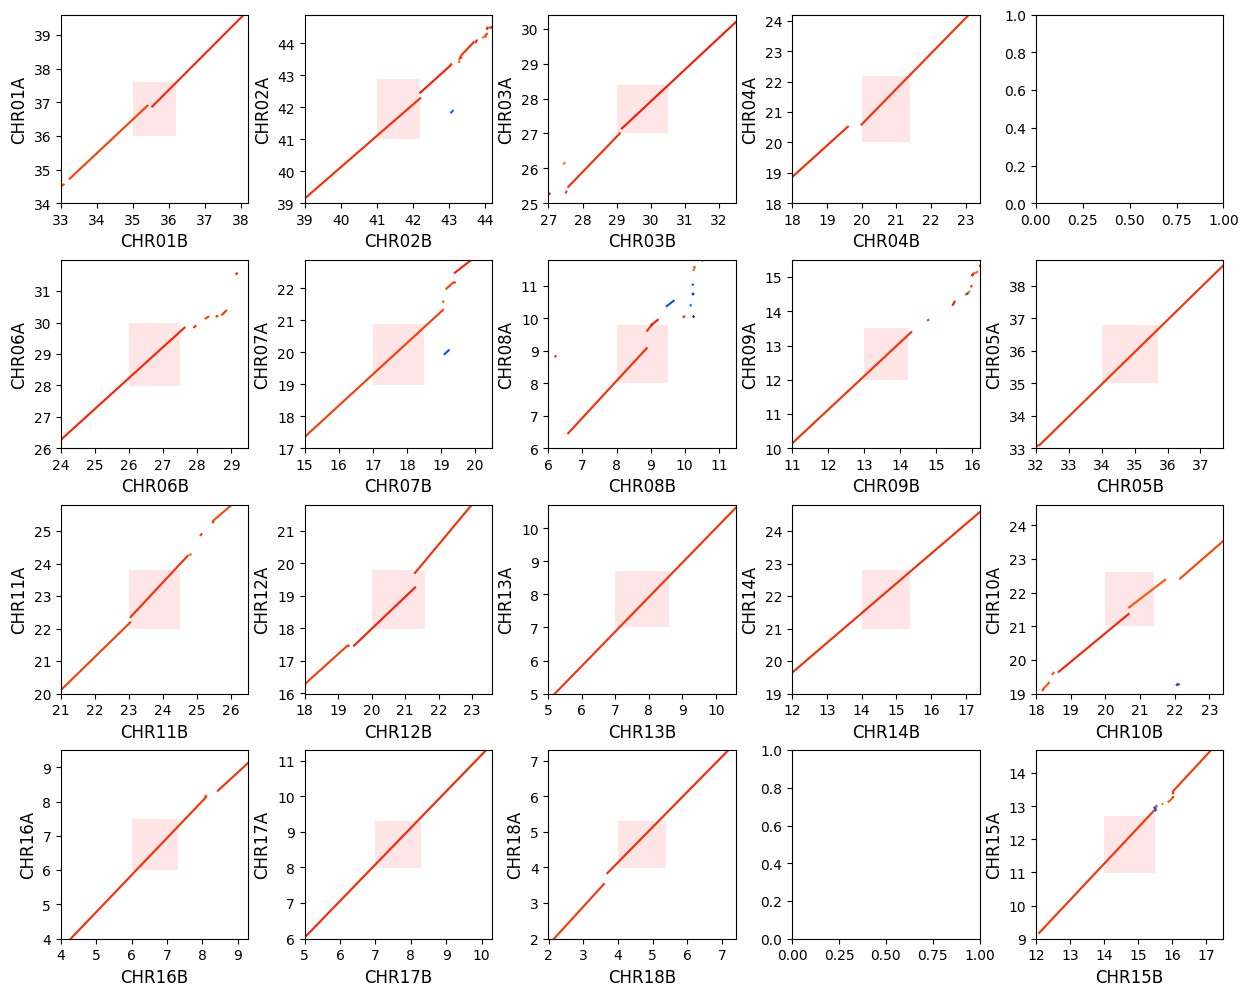

In [74]:
zoomplot(Au3_paf, 3, centromere, 'Au3_cen_zoomplot.svg')

In [63]:
import pybedtools

In [62]:
#input gene position
gene = pd.read_csv('../../data/Au3_deduplicate/Au3_deduplicate.gff3', sep='\t', header=None, comment='#')
gene.columns = ['Chr', 'Source', 'Type', 'Start', 'End', 'Score', 'Strand', 'Phase', 'Attributes']
gene['Chr'] = gene['Chr'].str.replace('AU3_HapA_CHR14ab', 'AU3_HapB_CHR14')
#If contains hapA, add A in the end, if contains hapB, add B in the end
gene['Chr'] = gene['Chr'].apply(lambda x: x + 'A' if 'HapA' in x else x + 'B')
gene['Chr'] = gene['Chr'].str.replace('AU3_HapA_CHR', 'CHR')
gene['Chr'] = gene['Chr'].str.replace('AU3_HapB_CHR', 'CHR')

In [64]:
gene_gene = gene[gene['Type'] == 'gene']

In [65]:
gene_bed = gene_gene[['Chr', 'Start', 'End']]

In [66]:
gene_bed = gene_bed.sort_values(['Chr', 'Start']).reset_index(drop=True)
gene_bed = pybedtools.BedTool.from_dataframe(gene_bed)
#merge the gene_bed
gene_bed = gene_bed.merge()

In [67]:
genome_size = pd.read_table('../../data/Au3.genome.size', sep=' ', header=None)
genome_size.columns = ['Chr', 'Size']
genome_size['Chr'] = genome_size['Chr'].str.replace('Chr', 'CHR')
genome_size = genome_size.sort_values('Chr').reset_index(drop=True)
genome_size['Start'] = 0
genome_size['End'] = genome_size['Size']
genome_size_bed = pybedtools.BedTool.from_dataframe(genome_size[['Chr', 'Start', 'End']])

In [68]:
window = []
for index, row in genome_size.iterrows():
    chr_name = row['Chr']
    chr_size = row['Size']
    start = 0
    window_size = 1000
    end = window_size
    while end <= chr_size:
        window.append([chr_name, start, end])
        start += window_size
        end += window_size        
    if end > chr_size:
        end = chr_size
        window.append([chr_name, start, chr_size])
#convert to dataframe
window = pd.DataFrame(window, columns=['Chr', 'Start', 'End'])

#window['Start'] = window['Start'].astype(int) - 1000 # 1kb overlap
#If start < 0, set to 0
#window['Start'] = window['Start'].apply(lambda x: 0 if x < 0 else x)
window_bed = pybedtools.BedTool.from_dataframe(window)


In [69]:
#Get coverage of gene_bed in window_bed
coverage = window_bed.coverage(gene_bed)
coverage_tmp = coverage.to_dataframe()
coverage_tmp.columns = ['Chr', 'Start', 'End', 'Count', 'Cov_size', 'Size', 'Coverage']

***** WARNING: File /tmp/pybedtools.tvnmeuu1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
CHR10A	28002	30671

***** WARNING: File /tmp/pybedtools.tvnmeuu1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
CHR10A	28002	30671



In [173]:
cen_gene_coverage[(cen_gene_coverage['Chr'] == 'CHR14B')]

,Chr,Start,End,Count,Cov_size,Size,Coverage
644263,CHR14B,4074000,4075000,0,0,1000,0.0
644264,CHR14B,4075000,4076000,0,0,1000,0.0
644265,CHR14B,4076000,4077000,0,0,1000,0.0
644266,CHR14B,4077000,4078000,0,0,1000,0.0
644267,CHR14B,4078000,4079000,0,0,1000,0.0
...,...,...,...,...,...,...,...
667757,CHR14B,27568000,27569000,0,0,1000,0.0
667758,CHR14B,27569000,27570000,0,0,1000,0.0
667759,CHR14B,27570000,27571000,0,0,1000,0.0
667760,CHR14B,27571000,27572000,0,0,1000,0.0


In [70]:
cen_gene_coverage = pd.DataFrame()
for i in centromere['Chr'].unique():
    Chr_tmp = i
    Cen_tmp = centromere[centromere['Chr'] == i]
    Cen_tmp_start = Cen_tmp['Start'].values[0] - 5000000
    Cen_tmp_end = Cen_tmp['End'].values[0] + 5000000
    #If start < 0, set to 0
    Cen_tmp_start = 0 if Cen_tmp_start < 0 else Cen_tmp_start
    coverage_tmp_tmp = coverage_tmp[(coverage_tmp['Chr'] == Chr_tmp) & (coverage_tmp['Start'] >= Cen_tmp_start) & (coverage_tmp['End'] <= Cen_tmp_end)]
    cen_gene_coverage = pd.concat([cen_gene_coverage, coverage_tmp_tmp])
cen_gene_coverage = cen_gene_coverage.reset_index(drop=True)

In [71]:
#Plot gene coverage in centromere region of each chromosome
def plot_gene_coverage(cen_gene_coverage, centromere, fsize):
    fig, ax = plt.subplots(5, 4, figsize=(fsize*5, fsize*2))
    for i in range(18):
        row = i // 4
        col = i % 4
        Chr_tmp = 'CHR' + str(i+1).zfill(2) + 'A'
        Cen_tmp = centromere[centromere['Chr'] == Chr_tmp]
        Cen_tmp_start = Cen_tmp['Start'].values[0]- 5000000
        Cen_tmp_end = Cen_tmp['End'].values[0] + 5000000
        Cen_tmp_start = Cen_tmp_start if Cen_tmp_start > 0 else 0
        x_chr_label_start = Cen_tmp['Start'].values[0]
        x_chr_label_end = Cen_tmp['End'].values[0]
        y_chr_label_start = 0
        y_chr_label_end = 1
        coverage_tmp_tmp = cen_gene_coverage[cen_gene_coverage['Chr'] == Chr_tmp]
        ax[row, col].bar(coverage_tmp_tmp['Start'], coverage_tmp_tmp['Coverage'], width=10000, color='b')
        ax[row, col].set_xlabel(Chr_tmp, fontsize=8)
        ax[row, col].set_ylabel('Cov', fontsize=8)
        ax[row, col].set_xlim(Cen_tmp_start, Cen_tmp_end)
        ax[row, col].set_ylim(0, 1)
        rectangle = Rectangle((x_chr_label_start, y_chr_label_start), (x_chr_label_end-x_chr_label_start), (y_chr_label_end-y_chr_label_start), linewidth=0, edgecolor='r', facecolor=(1.0, 0.8, 0.8, 0.5))
        ax[row, col].add_patch(rectangle)
    plt.subplots_adjust(wspace=0.5, hspace=0.8)
    plt.show()

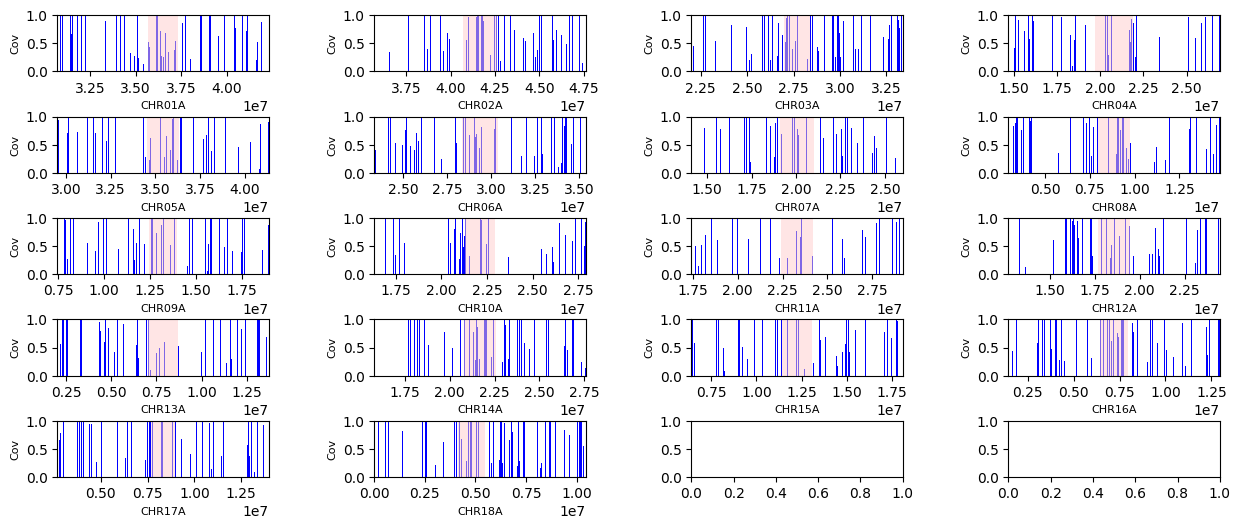

In [72]:
plot_gene_coverage(cen_gene_coverage, centromere, 3)

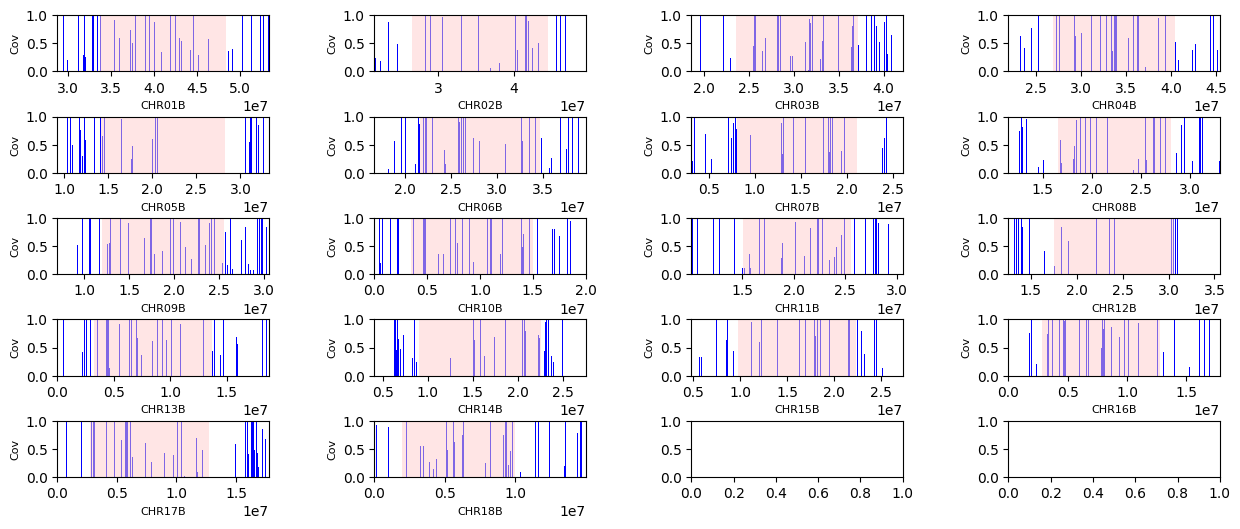

In [176]:
def plot_gene_coverage(cen_gene_coverage, centromere, fsize):
    fig, ax = plt.subplots(5, 4, figsize=(fsize*5, fsize*2))
    for i in range(18):
        row = i // 4
        col = i % 4
        Chr_tmp = 'CHR' + str(i+1).zfill(2) + 'B'
        Cen_tmp = centromere[centromere['Chr'] == Chr_tmp]
        Cen_tmp_start = Cen_tmp['Start'].values[0]- 5000000
        Cen_tmp_end = Cen_tmp['End'].values[0] + 5000000
        Cen_tmp_start = Cen_tmp_start if Cen_tmp_start > 0 else 0
        x_chr_label_start = Cen_tmp['Start'].values[0]
        x_chr_label_end = Cen_tmp['End'].values[0]
        y_chr_label_start = 0
        y_chr_label_end = 1
        coverage_tmp_tmp = cen_gene_coverage[cen_gene_coverage['Chr'] == Chr_tmp]
        ax[row, col].bar(coverage_tmp_tmp['Start'], coverage_tmp_tmp['Coverage'], width=10000, color='b')
        ax[row, col].set_xlabel(Chr_tmp, fontsize=8)
        ax[row, col].set_ylabel('Cov', fontsize=8)
        ax[row, col].set_xlim(Cen_tmp_start, Cen_tmp_end)
        ax[row, col].set_ylim(0, 1)
        rectangle = Rectangle((x_chr_label_start, y_chr_label_start), (x_chr_label_end-x_chr_label_start), (y_chr_label_end-y_chr_label_start), linewidth=0, edgecolor='r', facecolor=(1.0, 0.8, 0.8, 0.5))
        ax[row, col].add_patch(rectangle)
    plt.subplots_adjust(wspace=0.5, hspace=0.8)
    plt.show()

plot_gene_coverage(cen_gene_coverage, centromere, 3)

In [116]:
cen_gene_coverage

,Chr,Start,End,Count,Cov_size,Size,Coverage
0,CHR01A,29010000,29020000,0,0,10000,0.0000
1,CHR01A,29020000,29030000,0,0,10000,0.0000
2,CHR01A,29030000,29040000,0,0,10000,0.0000
3,CHR01A,29040000,29050000,0,0,10000,0.0000
4,CHR01A,29050000,29060000,0,0,10000,0.0000
...,...,...,...,...,...,...,...
47134,CHR18B,9930000,9940000,0,0,10000,0.0000
47135,CHR18B,9940000,9950000,0,0,10000,0.0000
47136,CHR18B,9950000,9960000,1,1988,10000,0.1988
47137,CHR18B,9960000,9970000,0,0,10000,0.0000


In [115]:
cen_gene_coverage

,Chr,Start,End,Count,Cov_size,Size,Coverage
0,CHR01A,29010000,29020000,0,0,10000,0.0000
1,CHR01A,29020000,29030000,0,0,10000,0.0000
2,CHR01A,29030000,29040000,0,0,10000,0.0000
3,CHR01A,29040000,29050000,0,0,10000,0.0000
4,CHR01A,29050000,29060000,0,0,10000,0.0000
...,...,...,...,...,...,...,...
47134,CHR18B,9930000,9940000,0,0,10000,0.0000
47135,CHR18B,9940000,9950000,0,0,10000,0.0000
47136,CHR18B,9950000,9960000,1,1988,10000,0.1988
47137,CHR18B,9960000,9970000,0,0,10000,0.0000


In [100]:
window[window['Chr'] == 'CHR18B']

,Chr,Start,End
202975,CHR18B,0,10000
202976,CHR18B,9000,20000
202977,CHR18B,19000,30000
202978,CHR18B,29000,40000
202979,CHR18B,39000,50000
...,...,...,...
205619,CHR18B,26439000,26450000
205620,CHR18B,26449000,26460000
205621,CHR18B,26459000,26470000
205622,CHR18B,26469000,26480000
